In [ ]:
!pip install torchaudio
!pip install torch
!pip install timm
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.6 MB/s eta 0:00:00


In [ ]:
#import necessary libraries
import os

import zipfile

import shutil

import random

import pandas as pd

import librosa

import numpy as np

import matplotlib.pyplot as plt

from scipy.io.wavfile import write

import torch

import torch.nn as nn

import torchaudio

import torchaudio.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import torch.optim as optim

from sklearn.metrics import accuracy_score, f1_score

from torchvision.models import resnet18

import torchaudio.transforms as transforms

import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import os

import zipfile



local_zip = 'release_in_the_wild.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('.')

zip_ref.close()

In [ ]:
import shutil
import random

base_dir = './'
fake_dir = os.path.join(base_dir, 'fake')
real_dir = os.path.join(base_dir, 'real')

# Create directories for train, validation, and test splits
def create_split_dirs(base_dir):
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split)
        os.makedirs(os.path.join(split_dir, 'fake'), exist_ok=True)
        os.makedirs(os.path.join(split_dir, 'real'), exist_ok=True)

create_split_dirs(base_dir)

# Helper function to split and move files
def split_data(source_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    files = os.listdir(source_dir)
    random.shuffle(files)  # Shuffle the files to randomize the split

    total_files = len(files)
    train_count = int(total_files * train_ratio)
    val_count = int(total_files * val_ratio)

    train_files = files[:train_count]
    val_files = files[train_count:train_count + val_count]
    test_files = files[train_count + val_count:]

    return train_files, val_files, test_files

# Move files to the appropriate split folders
def move_files(file_list, src_dir, dest_dir):
    for file in file_list:
        src_path = os.path.join(src_dir, file)
        dest_path = os.path.join(dest_dir, file)
        shutil.move(src_path, dest_path)

# Split fake and real data and move to corresponding folders
for category in ['fake', 'real']:
    category_dir = os.path.join(base_dir, category)

    train_files, val_files, test_files = split_data(category_dir)

    move_files(train_files, category_dir, os.path.join(base_dir, 'train', category))
    move_files(val_files, category_dir, os.path.join(base_dir, 'val', category))
    move_files(test_files, category_dir, os.path.join(base_dir, 'test', category))

print("Data split completed successfully!")


Data split completed successfully!


In [ ]:
# Display no of files in train, test, validation set

import pandas as pd


train_dir = './train'
val_dir = './val'
test_dir = './test'

# Helper function to count files in fake and real categories
def count_files_in_split(split_dir):
    fake_files = len(os.listdir(os.path.join(split_dir, 'fake')))
    real_files = len(os.listdir(os.path.join(split_dir, 'real')))
    return fake_files, real_files

# Count files in train, validation, and test splits
train_fake, train_real = count_files_in_split(train_dir)
val_fake, val_real = count_files_in_split(val_dir)
test_fake, test_real = count_files_in_split(test_dir)

# Display results
print(f"Train set: {train_fake} fake, {train_real} real")
print(f"Validation set: {val_fake} fake, {val_real} real")
print(f"Test set: {test_fake} fake, {test_real} real")



Train set: 9452 fake, 15970 real
Validation set: 1181 fake, 1996 real
Test set: 1183 fake, 1997 real


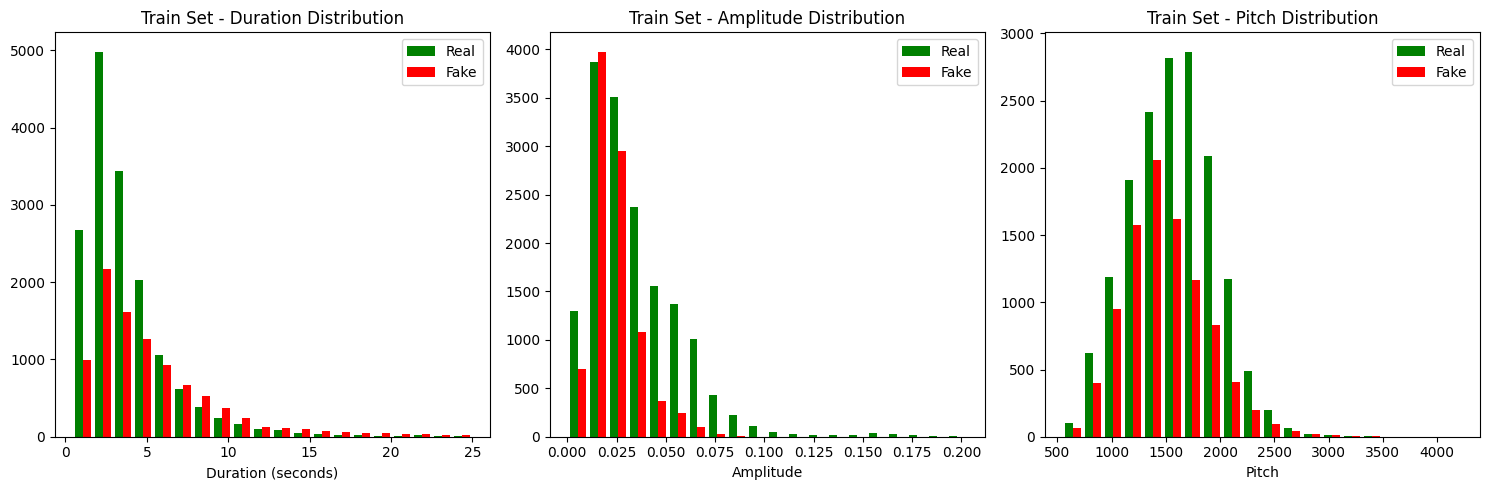

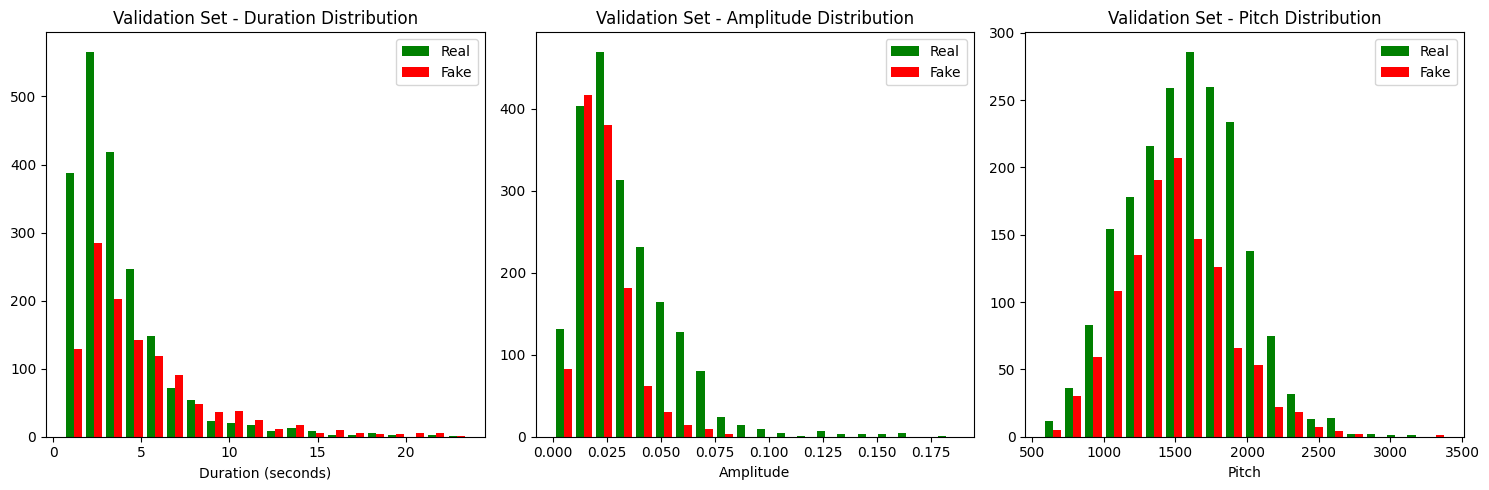

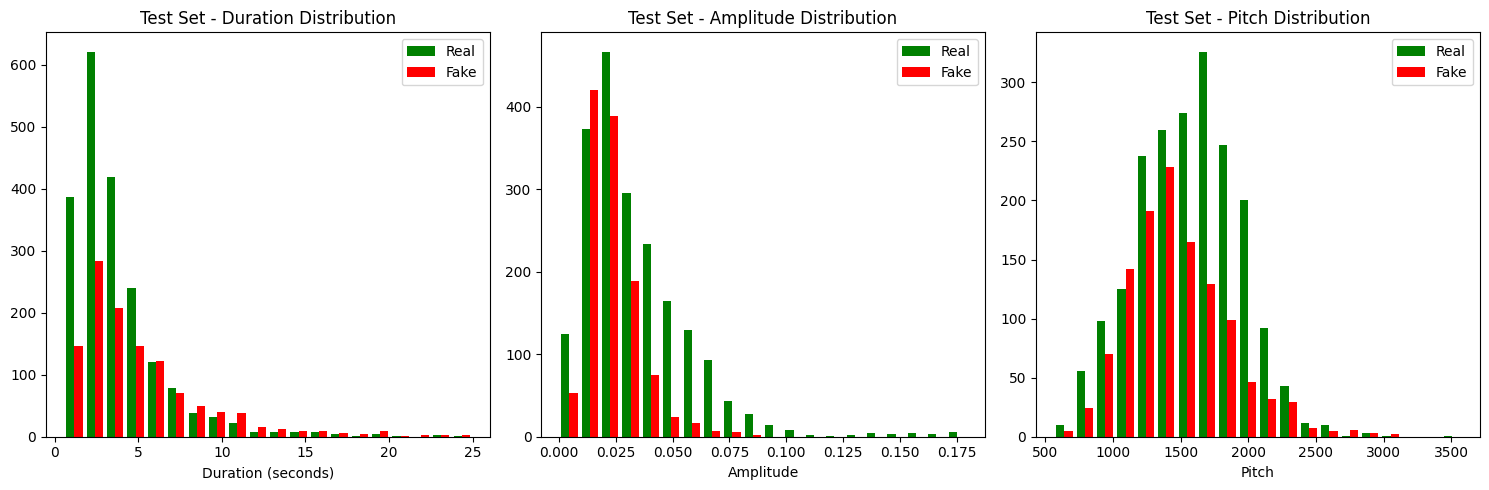

In [ ]:
# visualization of duration, amplitute and pitch distribution

import librosa

import numpy as np

import matplotlib.pyplot as plt



# Function to extract audio features (duration, amplitude, pitch)

def extract_audio_features(file_path):

    audio, sr = librosa.load(file_path, sr=None)

    duration = librosa.get_duration(y=audio, sr=sr)

    amplitude = np.mean(np.abs(audio))

    pitch = librosa.feature.spectral_centroid(y=audio, sr=sr).mean()

    return duration, amplitude, pitch





# Analyze the dataset and extract features from train/test/val directories

def analyze_audio_features(split_dir):

    data = {'filename': [], 'label': [], 'duration': [], 'amplitude': [], 'pitch': []}



    for label in ['fake', 'real']:

        label_dir = os.path.join(split_dir, label)

        for file in os.listdir(label_dir):

            file_path = os.path.join(label_dir, file)

            duration, amplitude, pitch = extract_audio_features(file_path)

            data['filename'].append(file)

            data['label'].append(label)

            data['duration'].append(duration)

            data['amplitude'].append(amplitude)

            data['pitch'].append(pitch)



    df = pd.DataFrame(data)

    return df





# Function to plot distribution comparisons between real and fake audios

def plot_feature_distributions(features_df, dataset_name):

    df_real = features_df[features_df['label'] == 'real']

    df_fake = features_df[features_df['label'] == 'fake']



    plt.figure(figsize=(15, 5))



    plt.subplot(1, 3, 1)

    plt.hist([df_real['duration'], df_fake['duration']], label=['Real', 'Fake'], bins=20, color=['green', 'red'])

    plt.title(f'{dataset_name} - Duration Distribution')

    plt.xlabel('Duration (seconds)')

    plt.legend()



    plt.subplot(1, 3, 2)

    plt.hist([df_real['amplitude'], df_fake['amplitude']], label=['Real', 'Fake'], bins=20, color=['green', 'red'])

    plt.title(f'{dataset_name} - Amplitude Distribution')

    plt.xlabel('Amplitude')

    plt.legend()



    plt.subplot(1, 3, 3)

    plt.hist([df_real['pitch'], df_fake['pitch']], label=['Real', 'Fake'], bins=20, color=['green', 'red'])

    plt.title(f'{dataset_name} - Pitch Distribution')

    plt.xlabel('Pitch')

    plt.legend()



    plt.tight_layout()

    plt.show()









# Extract audio features for each split (Train, Validation, Test)

train_features_df = analyze_audio_features(train_dir)

val_features_df = analyze_audio_features(val_dir)

test_features_df = analyze_audio_features(test_dir)



# Plot feature distributions for train, validation, and test sets

plot_feature_distributions(train_features_df, "Train Set")

plot_feature_distributions(val_features_df, "Validation Set")

plot_feature_distributions(test_features_df, "Test Set")


In [ ]:
import os

import librosa

import numpy as np

import pandas as pd

import shutil



# Function to check the quality of an audio file

def check_audio_quality(file_path):

    try:

        audio, sr = librosa.load(file_path, sr=None)

        if np.max(np.abs(audio)) == 0:

            return 'silent'

        if len(audio) < sr:  # Less than 1 second

            return 'low_quality'

        return 'good'

    except Exception:

        return 'corrupted'



# Analyze the audio quality in a given split (train/test/val)

def analyze_audio_quality(split_dir):

    quality_data = {'filename': [], 'label': [], 'quality': []}



    for label in ['fake', 'real']:

        folder_path = os.path.join(split_dir, label)

        for file in os.listdir(folder_path):

            file_path = os.path.join(folder_path, file)

            quality = check_audio_quality(file_path)

            quality_data['filename'].append(file)

            quality_data['label'].append(label)

            quality_data['quality'].append(quality)



    df = pd.DataFrame(quality_data)

    return df



# Function to remove low-quality audio files

def remove_low_quality_data(df, split_dir):

    for index, row in df.iterrows():

        if row['quality'] in ['silent', 'low_quality', 'corrupted']:

            label = row['label']

            file_path = os.path.join(split_dir, label, row['filename'])

            if os.path.exists(file_path):

                os.remove(file_path)

                print(f"Removed {file_path} (quality: {row['quality']})")





# Analyze the audio quality of each dataset

train_quality_df = analyze_audio_quality(train_dir)

val_quality_df = analyze_audio_quality(val_dir)

test_quality_df = analyze_audio_quality(test_dir)



# Print quality distribution for each dataset

print("Train Set Quality Distribution:")

print(train_quality_df['quality'].value_counts())



print("\nValidation Set Quality Distribution:")

print(val_quality_df['quality'].value_counts())



print("\nTest Set Quality Distribution:")

print(test_quality_df['quality'].value_counts())



# Remove low-quality audio files from each dataset

remove_low_quality_data(train_quality_df, train_dir)

remove_low_quality_data(val_quality_df, val_dir)

remove_low_quality_data(test_quality_df, test_dir)



print("Low-quality audio files removed successfully.")


Train Set Quality Distribution:
quality
good           24721
low_quality      701
Name: count, dtype: int64

Validation Set Quality Distribution:
quality
good           3099
low_quality      78
Name: count, dtype: int64

Test Set Quality Distribution:
quality
good           3094
low_quality      86
Name: count, dtype: int64
Removed ./train/fake/25031.wav (quality: low_quality)
Removed ./train/fake/30142.wav (quality: low_quality)
Removed ./train/fake/23803.wav (quality: low_quality)
Removed ./train/fake/18032.wav (quality: low_quality)
Removed ./train/fake/9760.wav (quality: low_quality)
Removed ./train/fake/7624.wav (quality: low_quality)
Removed ./train/fake/22804.wav (quality: low_quality)
Removed ./train/fake/21797.wav (quality: low_quality)
Removed ./train/fake/25022.wav (quality: low_quality)
Removed ./train/fake/24753.wav (quality: low_quality)
Removed ./train/fake/7863.wav (quality: low_quality)
Removed ./train/fake/1182.wav (quality: low_quality)
Removed ./train/fake/11945.wav

In [ ]:


import torch

import torch.nn as nn

import torchaudio

import torchaudio.transforms as transforms

from torch.utils.data import Dataset, DataLoader



# Set parameters for the Mel-spectrogram

height = 50  # Number of Mel bands

target_length = 250  # Target length for the spectrogram

sample_rate = 16000  # Default sample rate for the audio files

n_fft = 2048  # FFT window size

hop_length = 512  # Hop length for the Mel-spectrogram

n_mels = height  # Number of Mel filters
subset_fraction=0.7


# Define the device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# Define the AudioDataset for data preparation for the models resnet,re2net,senet

class AudioDataset(Dataset):

    def __init__(self, root_dir, target_length=target_length, subset_fraction=subset_fraction, augment=False):

        self.root_dir = root_dir

        self.data = []

        self.labels = []

        self.target_length = target_length

        self.augment = augment  # Whether to apply data augmentation



        # Load file paths and labels

        for label in ['fake', 'real']:

            label_dir = os.path.join(self.root_dir, label)

            for file_name in os.listdir(label_dir):

                if file_name.endswith('.wav'):

                    self.data.append(os.path.join(label_dir, file_name))

                    self.labels.append(0 if label == 'fake' else 1)



        # Randomly sample a subset of the dataset

        total_samples = len(self.data)

        subset_size = int(total_samples * subset_fraction)

        indices = random.sample(range(total_samples), subset_size)



        self.data = [self.data[i] for i in indices]

        self.labels = [self.labels[i] for i in indices]



        # Define the Mel-spectrogram transform

        self.mel_transform = transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft,

                                                       hop_length=hop_length, n_mels=n_mels)



    def __len__(self):

        return len(self.data)



    def __getitem__(self, idx):

        # Load the audio file with error handling

        wav_path = self.data[idx]

        try:

            waveform, sample_rate = torchaudio.load(wav_path)

        except Exception as e:

            print(f"Error loading {wav_path}: {e}")

            return None  # Handle the error gracefully



        # Data augmentation (e.g., adding white noise)

        if self.augment:

            noise = torch.randn_like(waveform) * 0.005  # Adjust noise level as needed

            waveform += noise



        # Convert to Mel-Spectrogram

        mel_spectrogram = self.mel_transform(waveform)



        # Normalize the spectrogram

        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()



        # Pad or truncate the spectrogram to the target length

        if mel_spectrogram.size(2) < self.target_length:

            padding = self.target_length - mel_spectrogram.size(2)

            mel_spectrogram = nn.functional.pad(mel_spectrogram, (0, padding), "constant", 0)

        elif mel_spectrogram.size(2) > self.target_length:

            mel_spectrogram = mel_spectrogram[:, :, :self.target_length]



        # Ensure mel_spectrogram has the shape [3, height, target_length]

        if mel_spectrogram.size(0) == 1:  # Check if it's a single channel

            mel_spectrogram = mel_spectrogram.expand(3, -1, -1)  # Expand to 3 channels



        # Convert label to tensor

        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Change to long for CrossEntropyLoss



        return mel_spectrogram, label





# Create train and validation datasets and loaders

train_dataset = AudioDataset(root_dir=train_dir, target_length=target_length, subset_fraction=0.7, augment=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



val_dataset = AudioDataset(root_dir=val_dir, target_length=target_length, subset_fraction=1.0)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



test_dataset = AudioDataset(root_dir=test_dir, target_length=target_length, subset_fraction=1.0)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)




In [ ]:
def save_model(model, model_name):

    """Saves the model weights."""

    torch.save(model.state_dict(), f'{model_name}_best_model.pth')

    print(f'Model saved as {model_name}_best_model.pth')

# training loop for senet,resnet,res2net 
def train_model(model, train_loader, val_loader, num_epochs, model_name):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Ensure the model is on the correct device
    model.to(device)

    best_model_wts = model.state_dict()
    best_accuracy = 0.0

    # Lists to store accuracy for plotting
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for mel_spectrogram, labels in train_loader:  # Unpack the tuple here
            mel_spectrogram = mel_spectrogram.to(device)  # Move mel-spectrogram to device
            labels = labels.to(device)  # Move labels to device

            optimizer.zero_grad()
            outputs = model(mel_spectrogram)  # Pass the mel-spectrogram to the model
            loss = criterion(outputs.view(-1), labels.float())  # Ensure the labels are float
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predictions.view(-1) == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train  # Calculate training accuracy
        train_accuracies.append(train_accuracy)  # Store training accuracy
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation step
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for mel_spectrogram, labels in val_loader:  # Unpack the tuple here
                mel_spectrogram = mel_spectrogram.to(device)  # Move to device
                labels = labels.to(device)  # Move to device

                outputs = model(mel_spectrogram)
                predictions = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predictions.view(-1) == labels).sum().item()

        accuracy = correct / total
        val_accuracies.append(accuracy)  # Store validation accuracy
        print(f"Validation Accuracy: {accuracy:.4f}")

        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")

    # Save the best model weights
    save_model(model, model_name)

    # Plot accuracy vs epochs
    plt.figure(figsize=(10, 5))  # Create a new figure with a specified size
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='red')  # Red for training accuracy
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o', color='blue')  # Blue for validation accuracy
    plt.title('Accuracy vs Epochs')  # Title of the plot
    plt.xlabel('Epochs')  # X-axis label
    plt.ylabel('Accuracy')  # Y-axis label
    plt.xticks(range(1, num_epochs + 1))  # Set x-ticks to be the epoch numbers
    plt.legend()  # Show the legend
    plt.grid()  # Add a grid for easier reading
    plt.show()  # Display the plot

    return model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 209MB/s]


Epoch [1/10], Loss: 0.4509, Training Accuracy: 0.7950
Validation Accuracy: 0.5763
Epoch [2/10], Loss: 0.2928, Training Accuracy: 0.8785
Validation Accuracy: 0.8203
Epoch [3/10], Loss: 0.2303, Training Accuracy: 0.9071
Validation Accuracy: 0.7083
Epoch [4/10], Loss: 0.2008, Training Accuracy: 0.9200
Validation Accuracy: 0.8842
Epoch [5/10], Loss: 0.1596, Training Accuracy: 0.9371
Validation Accuracy: 0.8938
Epoch [6/10], Loss: 0.1481, Training Accuracy: 0.9429
Validation Accuracy: 0.8454
Epoch [7/10], Loss: 0.1247, Training Accuracy: 0.9517
Validation Accuracy: 0.8745
Epoch [8/10], Loss: 0.1120, Training Accuracy: 0.9557
Validation Accuracy: 0.8561
Epoch [9/10], Loss: 0.0893, Training Accuracy: 0.9667
Validation Accuracy: 0.9177
Epoch [10/10], Loss: 0.0766, Training Accuracy: 0.9706
Validation Accuracy: 0.9342
Best Validation Accuracy: 0.9342
Model saved as resnet_model_best_model.pth


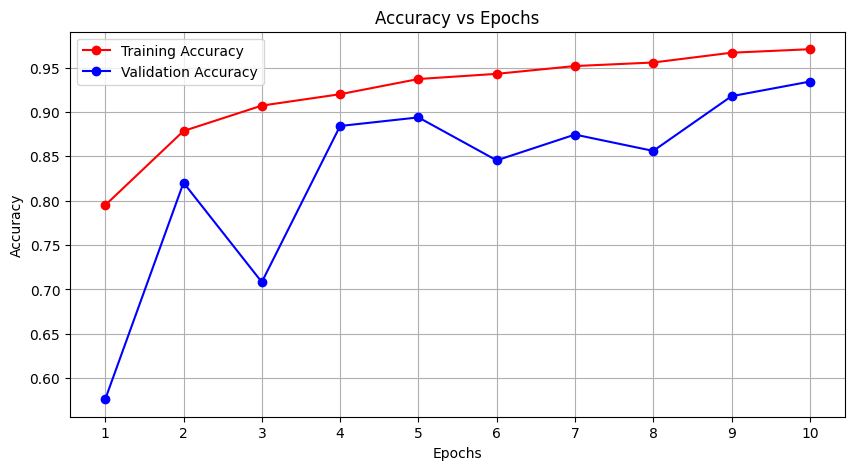

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

from torchvision.models import resnet18


# Resnet model 
class ResNetClassifier(nn.Module):

    def __init__(self):

        super(ResNetClassifier, self).__init__()

        self.model = resnet18(weights='IMAGENET1K_V1')



        # Replace the fully connected layer with a new one for binary classification

        num_features = self.model.fc.in_features  # Get the number of features from the original ResNet's last layer

        self.model.fc = nn.Linear(num_features, 1)  # Change output size to 1 for binary classification



    def forward(self, x):

        return self.model(x)  # Output is passed through the modified fully connected layer





# Train the model

resnet_model =train_model(ResNetClassifier(), train_loader, val_loader, num_epochs=10,model_name='resnet_model')




--2024-10-26 09:30:05--  https://raw.githubusercontent.com/Res2Net/Res2Net-PretrainedModels/master/res2net.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8750 (8.5K) [text/plain]
Saving to: ‘res2net.py’

res2net.py          100%[===================>]   8.54K  --.-KB/s    in 0s      

2024-10-26 09:30:05 (77.0 MB/s) - ‘res2net.py’ saved [8750/8750]

Epoch [1/10], Loss: 0.6250, Training Accuracy: 0.7008
Validation Accuracy: 0.7861
Epoch [2/10], Loss: 0.4408, Training Accuracy: 0.8061
Validation Accuracy: 0.7864
Epoch [3/10], Loss: 0.3505, Training Accuracy: 0.8509
Validation Accuracy: 0.8477
Epoch [4/10], Loss: 0.2964, Training Accuracy: 0.8757
Validation Accuracy: 0.7406
Epoch [5/10], Loss: 0.2515, Training Accuracy: 0.8992
Validation Accuracy: 0.8745
Epo

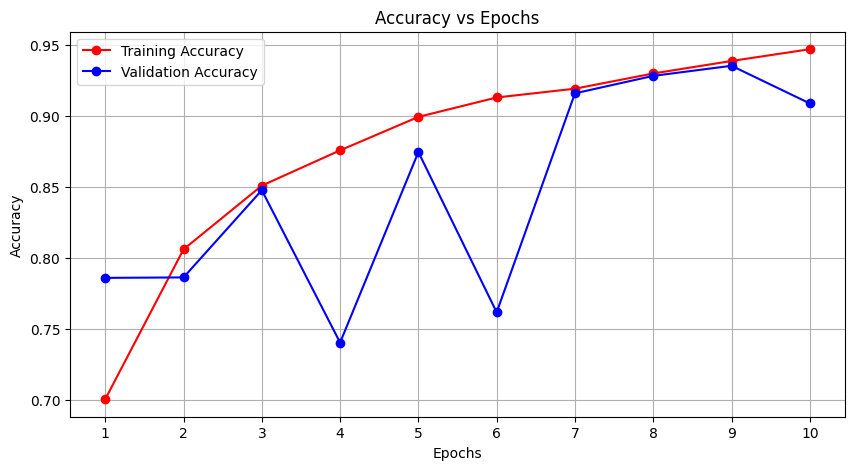

In [ ]:
!wget https://raw.githubusercontent.com/Res2Net/Res2Net-PretrainedModels/master/res2net.py



from res2net import res2net50



# Define Res2Net model for binary classification

class Res2NetClassifier(nn.Module):

    def __init__(self):

        super(Res2NetClassifier, self).__init__()

        self.model = res2net50()

        self.fc = nn.Linear(1000, 1)  # Change output size to 1 for binary classification



    def forward(self, x):

        x = self.model(x)

        x = self.fc(x)  # Fully connected layer

        return x  # Return logits





res2net_model=train_model(Res2NetClassifier(), train_loader, val_loader, num_epochs=10,model_name='res2net_model')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/461M [00:00<?, ?B/s]

Epoch [1/10], Loss: 0.3740, Training Accuracy: 0.8316
Validation Accuracy: 0.7464
Epoch [2/10], Loss: 0.1995, Training Accuracy: 0.9208
Validation Accuracy: 0.9074
Epoch [3/10], Loss: 0.1423, Training Accuracy: 0.9461
Validation Accuracy: 0.8312
Epoch [4/10], Loss: 0.1089, Training Accuracy: 0.9602
Validation Accuracy: 0.9400
Epoch [5/10], Loss: 0.0952, Training Accuracy: 0.9645
Validation Accuracy: 0.8964
Epoch [6/10], Loss: 0.0762, Training Accuracy: 0.9723
Validation Accuracy: 0.9197
Epoch [7/10], Loss: 0.0652, Training Accuracy: 0.9773
Validation Accuracy: 0.8509
Epoch [8/10], Loss: 0.0524, Training Accuracy: 0.9806
Validation Accuracy: 0.8822
Epoch [9/10], Loss: 0.0464, Training Accuracy: 0.9836
Validation Accuracy: 0.9626
Epoch [10/10], Loss: 0.0449, Training Accuracy: 0.9842
Validation Accuracy: 0.9522
Best Validation Accuracy: 0.9626
Model saved as senet_model_best_model.pth


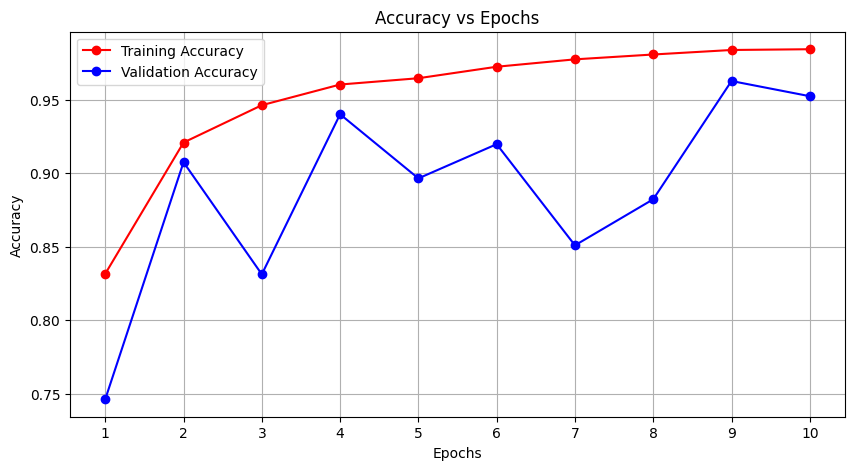

In [ ]:
import timm

#senet model for classification
class SENetClassifier(nn.Module):

    def __init__(self):

        super(SENetClassifier, self).__init__()

        self.model = timm.create_model('senet154', pretrained=True)

        # Modify the classifier for binary classification

        self.model.fc = nn.Linear(self.model.fc.in_features, 1)  # Change output to 1 for binary classification



    def forward(self, x):

        return self.model(x)  # Directly return the output from the modified model



# Train the model

senet_model=train_model(SENetClassifier(), train_loader, val_loader, num_epochs=10,model_name='senet_model')


In [ ]:


import torchaudio.transforms as transforms

import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

from torch_geometric.data import Data

from sklearn.neighbors import kneighbors_graph

from torch_geometric.data import DataLoader as GeoDataLoader








import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# training loop for GNN

def train_model_graph(model, train_loader_graph, val_loader_graph, num_epochs, model_name):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = model.state_dict()
    best_accuracy = 0.0

    # Lists to store accuracy for plotting
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for data in train_loader_graph:  # Use the correct data loader
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass with the correct arguments
            outputs = model(data.x, data.edge_index, data.batch)  # Ensure all required args are passed

            labels = data.y.float()  # Ensure labels are in the correct format
            loss = criterion(outputs.view(-1), labels.view(-1))  # Reshape as necessary

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predictions.view(-1) == labels.view(-1)).sum().item()

        avg_loss = running_loss / len(train_loader_graph)
        train_accuracy = correct_train / total_train  # Calculate training accuracy
        train_accuracies.append(train_accuracy)  # Store training accuracy
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation step
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data in val_loader_graph:  # Ensure using the correct validation loader
                data = data.to(device)
                outputs = model(data.x, data.edge_index, data.batch)  # Pass the batch

                predictions = (torch.sigmoid(outputs) > 0.5).float()
                total += data.y.size(0)
                correct += (predictions.view(-1) == data.y.view(-1)).sum().item()

        accuracy = correct / total
        val_accuracies.append(accuracy)  # Store validation accuracy
        print(f"Validation Accuracy: {accuracy:.4f}")

        # Save the best model weights
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_wts = model.state_dict()

    # Save the best model weights
    torch.save(best_model_wts, f'{model_name}_best_model.pth')
    print(f'Model saved as {model_name}_best_model.pth')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    # Print the best accuracy achieved
    print(f'Best Validation Accuracy: {best_accuracy:.4f}')

    # Plot accuracy vs epochs
    plt.figure(figsize=(10, 5))  # Create a new figure with a specified size
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='red')  # Red for training accuracy
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o', color='blue')  # Blue for validation accuracy
    plt.title('Accuracy vs Epochs')  # Title of the plot
    plt.xlabel('Epochs')  # X-axis label
    plt.ylabel('Accuracy')  # Y-axis label
    plt.xticks(range(1, num_epochs + 1))  # Set x-ticks to be the epoch numbers
    plt.legend()  # Show the legend
    plt.grid()  # Add a grid for easier reading
    plt.show()  # Display the plot

    return model








# Set parameters for the Mel-spectrogram

height = 50  # Number of Mel bands

target_length = 250  # Target length for the spectrogram

sample_rate = 16000  # Default sample rate for the audio files

n_fft = 2048  # FFT window size

hop_length = 512  # Hop length for the Mel-spectrogram

subset_fraction=0.7

# Define the AudioGraphDataset for GNN

class AudioGraphDataset(Dataset):

    def __init__(self, root_dir, subset_fraction=subset_fraction, augment=False):

        self.root_dir = root_dir

        self.data = []

        self.labels = []

        self.augment = augment  # Whether to apply data augmentation

        self.mel_transform = transforms.MelSpectrogram(

            sample_rate=sample_rate,

            n_fft=n_fft,

            hop_length=hop_length,

            n_mels=height

        )



        # Load file paths and labels

        for label in ['fake', 'real']:

            label_dir = os.path.join(self.root_dir, label)

            for file_name in os.listdir(label_dir):

                if file_name.endswith('.wav'):

                    self.data.append(os.path.join(label_dir, file_name))

                    self.labels.append(0 if label == 'fake' else 1)



        # Randomly sample a subset of the dataset

        total_samples = len(self.data)

        subset_size = int(total_samples * subset_fraction)

        indices = random.sample(range(total_samples), subset_size)



        self.data = [self.data[i] for i in indices]

        self.labels = [self.labels[i] for i in indices]



    def __len__(self):

        return len(self.data)



    def __getitem__(self, idx):

        # Load the audio file

        wav_path = self.data[idx]

        waveform, _ = torchaudio.load(wav_path)



        # Data augmentation (e.g., adding white noise)

        if self.augment:

            noise = torch.randn_like(waveform) * 0.005  # Adjust noise level as needed

            waveform += noise



        # Convert to Mel-Spectrogram

        mel_spectrogram = self.mel_transform(waveform)



        # Normalize the spectrogram

        mel_spectrogram = (mel_spectrogram - mel_spectrogram.mean()) / mel_spectrogram.std()



        # Pad or truncate the spectrogram to the target length

        if mel_spectrogram.size(2) < target_length:

            padding = target_length - mel_spectrogram.size(2)

            mel_spectrogram = F.pad(mel_spectrogram, (0, padding), "constant", 0)

        elif mel_spectrogram.size(2) > target_length:

            mel_spectrogram = mel_spectrogram[:, :, :target_length]



        # Create the graph representation

        edge_index = self.create_graph(mel_spectrogram)



        # Create node features from the Mel-spectrogram

        node_features = mel_spectrogram.squeeze(0).transpose(0, 1)  # Shape: [time, height]



        # Convert label to tensor

        label = torch.tensor(self.labels[idx], dtype=torch.float)  # Change to float for BCEWithLogitsLoss



        # Create and return a Data object

        return Data(x=node_features, edge_index=edge_index, y=label)



    def create_graph(self, mel_spectrogram):

        # Extract features for each frame (node)

        features = mel_spectrogram.squeeze(0).transpose(0, 1).numpy()  # Shape: [time, height]



        # Use K-nearest neighbors to create edges based on feature similarity

        n_neighbors = 5  # Number of neighbors to consider for the graph

        adjacency_matrix = kneighbors_graph(features, n_neighbors, mode='connectivity', include_self=True)



        # Convert adjacency matrix to a tensor with long data type

        edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long)  # Shape: [2, num_edges]



        return edge_index  # Return edge indices for the graph



# Create dataset and data loader

train_dataset_graph = AudioGraphDataset(root_dir=train_dir, subset_fraction=0.7, augment=True)

train_loader_graph = GeoDataLoader(train_dataset_graph, batch_size=32, shuffle=True)



val_dataset_graph = AudioGraphDataset(root_dir=val_dir, subset_fraction=1.0)

val_loader_graph = GeoDataLoader(val_dataset_graph, batch_size=32, shuffle=False)



test_dataset_graph = AudioGraphDataset(root_dir=test_dir, subset_fraction=1.0)

test_loader_graph = GeoDataLoader(test_dataset_graph, batch_size=32, shuffle=False)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


<ipython-input-18-c2d167b90f10>:292: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  edge_index = torch.tensor(adjacency_matrix.nonzero(), dtype=torch.long)  # Shape: [2, num_edges]


Epoch [1/10], Loss: 0.6177, Training Accuracy: 0.6633
Validation Accuracy: 0.6820
Epoch [2/10], Loss: 0.5735, Training Accuracy: 0.7065
Validation Accuracy: 0.7062
Epoch [3/10], Loss: 0.5530, Training Accuracy: 0.7246
Validation Accuracy: 0.7214
Epoch [4/10], Loss: 0.5356, Training Accuracy: 0.7371
Validation Accuracy: 0.7343
Validation Accuracy: 0.7398
Epoch [6/10], Loss: 0.5091, Training Accuracy: 0.7583
Validation Accuracy: 0.7508
Epoch [7/10], Loss: 0.4988, Training Accuracy: 0.7631
Validation Accuracy: 0.7495
Epoch [8/10], Loss: 0.4887, Training Accuracy: 0.7696
Validation Accuracy: 0.7683
Epoch [9/10], Loss: 0.4804, Training Accuracy: 0.7758
Validation Accuracy: 0.7708
Epoch [10/10], Loss: 0.4726, Training Accuracy: 0.7795
Validation Accuracy: 0.7679
Model saved as gnn_model_best_model.pth
Best Validation Accuracy: 0.7708


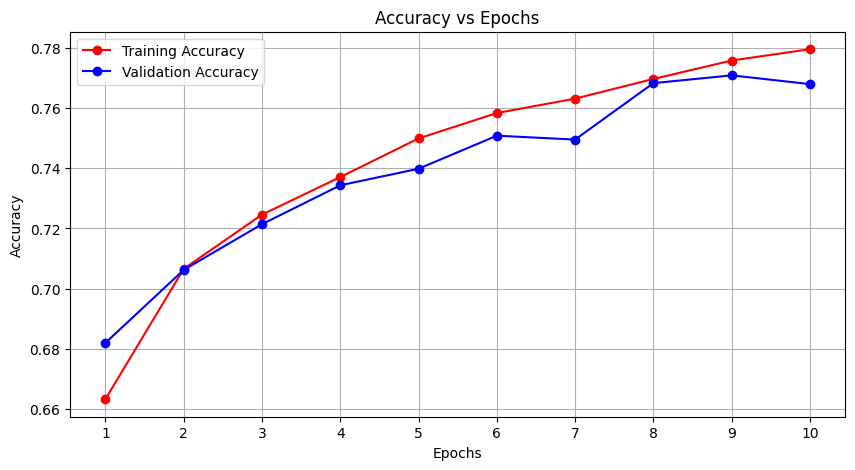

In [ ]:
import torch

import torch.nn as nn  # Import nn module from PyTorch

import torch_geometric



from torch_geometric.nn import GCNConv  # Import Graph Convolutional Network layer from PyTorch Geometric



import torch.nn as nn

import torch_geometric.nn as pyg_nn

import torch.nn.functional as F

from torch_geometric.nn import GCNConv, global_mean_pool  # Ensure global_mean_pool is imported

# GNN model 

class GNNClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):

        super(GNNClassifier, self).__init__()

        self.conv1 = GCNConv(input_dim, hidden_dim)

        self.conv2 = GCNConv(hidden_dim, output_dim)



    def forward(self, x, edge_index, batch):

        x = self.conv1(x, edge_index)

        x = F.relu(x)

        x = self.conv2(x, edge_index)



        # Global mean pooling

        x = global_mean_pool(x, batch)  # Ensure this is defined

        return x



gnn = GNNClassifier(input_dim=height, hidden_dim=32, output_dim=1)



gnn_model =train_model_graph(gnn, train_loader_graph, test_loader_graph, num_epochs=10,model_name='gnn_model')


In [ ]:
# Define the AudioDataset_DART_LSTM

class AudioDataset_DARTS_LSTM(Dataset):

    def __init__(self, root_dir, target_length=target_length, subset_fraction=subset_fraction, augment=False):

        self.root_dir = root_dir

        self.data = []

        self.labels = []

        self.target_length = target_length

        self.augment = augment  # Whether to apply data augmentation



        # Load file paths and labels

        for label in ['fake', 'real']:

            label_dir = os.path.join(self.root_dir, label)

            for file_name in os.listdir(label_dir):

                if file_name.endswith('.wav'):

                    self.data.append(os.path.join(label_dir, file_name))

                    self.labels.append(0 if label == 'fake' else 1)



        # Randomly sample a subset of the dataset

        total_samples = len(self.data)

        subset_size = int(total_samples * subset_fraction)

        indices = random.sample(range(total_samples), subset_size)



        self.data = [self.data[i] for i in indices]

        self.labels = [self.labels[i] for i in indices]



    def __len__(self):

        return len(self.data)



    def __getitem__(self, idx):

        # Load the audio file

        wav_path = self.data[idx]

        waveform, sample_rate = torchaudio.load(wav_path)



        # Data augmentation (optional)

        if self.augment:

            noise = torch.randn_like(waveform) * 0.005

            waveform += noise



        # Convert to Mel-spectrogram

        mel_spectrogram = torchaudio.transforms.MelSpectrogram()(waveform)



        # Pad or truncate to target length

        if mel_spectrogram.size(2) < self.target_length:

            padding = self.target_length - mel_spectrogram.size(2)

            mel_spectrogram = F.pad(mel_spectrogram, (0, padding), "constant", 0)

        elif mel_spectrogram.size(2) > self.target_length:

            mel_spectrogram = mel_spectrogram[:, :, :self.target_length]



        # Convert label to tensor

        label = torch.tensor(self.labels[idx], dtype=torch.long)



        # Ensure the Mel-spectrogram has the shape [time, height] for LSTM

        mel_spectrogram = mel_spectrogram.squeeze(0)  # Remove the channel dimension



        # Return as dictionary with x (features) and y (label)

        return {'x': mel_spectrogram.transpose(0, 1), 'y': label}  # Transpose to [time, height]



# Create train and validation datasets and loaders

train_dataset_DARTS_LSTM = AudioDataset_DARTS_LSTM(root_dir=train_dir, target_length=200, subset_fraction=0.7, augment=True)

train_loader_DARTS_LSTM = DataLoader(train_dataset_DARTS_LSTM, batch_size=32, shuffle=True)



val_dataset_DARTS_LSTM = AudioDataset_DARTS_LSTM(root_dir=val_dir, target_length=200, subset_fraction=1.0)

val_loader_DARTS_LSTM = DataLoader(val_dataset_DARTS_LSTM, batch_size=32, shuffle=False)





test_dataset_DARTS_LSTM = AudioDataset_DARTS_LSTM(root_dir=test_dir, subset_fraction=1.0)

test_loader_DARTS_LSTM = DataLoader(test_dataset_DARTS_LSTM, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# training loop for darts and lstm 

def train_model_DARTS_LSTM(model, train_loader, val_loader, num_epochs, model_name):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_model_wts = model.state_dict()
    best_accuracy = 0.0

    # Lists to store accuracy for plotting
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            inputs = batch['x'].to(device)
            labels = batch['y'].to(device).float()  # Convert labels to float for BCEWithLogitsLoss

            optimizer.zero_grad()
            outputs = model(inputs)  # Forward pass

            loss = criterion(outputs.view(-1), labels.view(-1))  # Reshape as necessary
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate training accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            total_train += labels.size(0)
            correct_train += (predictions.view(-1) == labels.view(-1)).sum().item()

        avg_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train  # Calculate training accuracy
        train_accuracies.append(train_accuracy)  # Store training accuracy
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation step
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['x'].to(device)
                labels = batch['y'].to(device).float()

                outputs = model(inputs)
                predictions = (torch.sigmoid(outputs) > 0.5).float()

                total += labels.size(0)
                correct += (predictions.view(-1) == labels.view(-1)).sum().item()

        accuracy = correct / total
        val_accuracies.append(accuracy)  # Store validation accuracy
        print(f"Validation Accuracy: {accuracy:.4f}")

        # Save the best model weights
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_wts = model.state_dict()

    # Save the best model weights
    torch.save(best_model_wts, f'{model_name}_best_model.pth')
    print(f'Model saved as {model_name}_best_model.pth')

    # Print the best accuracy achieved
    print(f'Best Validation Accuracy: {best_accuracy:.4f}')

    # Plot accuracy vs epochs
    plt.figure(figsize=(10, 5))  # Create a new figure with a specified size
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o', color='red')  # Red for training accuracy
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', marker='o', color='blue')  # Blue for validation accuracy
    plt.title('Accuracy vs Epochs')  # Title of the plot
    plt.xlabel('Epochs')  # X-axis label
    plt.ylabel('Accuracy')  # Y-axis label
    plt.xticks(range(1, num_epochs + 1))  # Set x-ticks to be the epoch numbers
    plt.legend()  # Show the legend
    plt.grid()  # Add a grid for easier reading
    plt.show()  # Display the plot

    return model


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Epoch [1/10], Loss: 0.6397, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Epoch [2/10], Loss: 0.6368, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Epoch [3/10], Loss: 0.5985, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Epoch [4/10], Loss: 0.6122, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Epoch [5/10], Loss: 0.5981, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Epoch [6/10], Loss: 0.6026, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Epoch [7/10], Loss: 0.6083, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Epoch [8/10], Loss: 0.5910, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Epoch [9/10], Loss: 0.5723, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Epoch [10/10], Loss: 0.5584, Training Accuracy: 0.6248
Validation Accuracy: 0.6241
Model saved as Darts_model_best_model.pth
Best Validation Accuracy: 0.6241


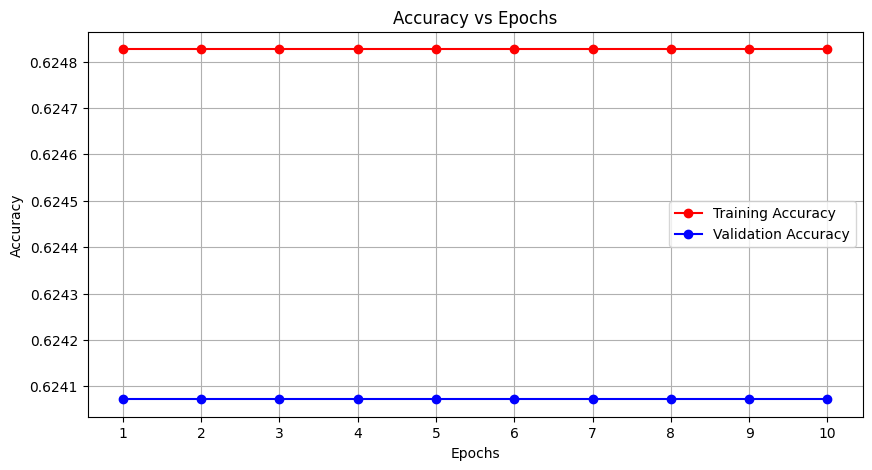

In [ ]:
import torch

import torch.nn as nn

import torch.optim as optim

from torch.utils.data import DataLoader



# Define LSTM Cell for the PC-DARTS search space

class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size):

        super(LSTMCell, self).__init__()

        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)



    def forward(self, x):

        output, (hn, cn) = self.lstm(x)

        if len(output.shape) == 2:  # If output is 2D, reshape to 3D

            output = output.unsqueeze(1)  # Shape it to [batch_size, 1, hidden_size]

        return output[:, -1, :]  # Return the last output





# Define the architecture search model

class PC_DARTS_Model(nn.Module):

    def __init__(self, input_size, hidden_size, search_space):

        super(PC_DARTS_Model, self).__init__()

        self.search_space = search_space

        self.layers = nn.ModuleList()



        # Here you would dynamically add layers based on your search space

        for i in range(len(search_space)):

            self.layers.append(LSTMCell(input_size, hidden_size))

            input_size = hidden_size  # Update input size for the next layer



        self.fc = nn.Linear(hidden_size, 1)  # Output for binary classification



    def forward(self, x):

        for layer in self.layers:

            x = layer(x)  # x should have shape [batch_size, hidden_size]

        x = self.fc(x)  # x will now be [batch_size, 1]

        return torch.sigmoid(x)  # This gives shape [batch_size, 1]





def create_search_space():

    search_space = [

        {

            "type": "LSTM",                      # Type of the layer

            "params": {                          # Parameters for the layer

                "hidden_size": 128,              # Hidden size of the LSTM

                "num_layers": 2,                 # Number of LSTM layers

                "dropout": 0.2                    # Dropout rate for regularization

            }

        },

        {

            "type": "LSTM",                      # Type of the layer

            "params": {

                "hidden_size": 64,               # Hidden size of the LSTM

                "num_layers": 1,                 # Number of LSTM layers

                "dropout": 0.3                    # Dropout rate for regularization

            }

        },

        {

            "type": "LSTM",                      # Type of the layer

            "params": {

                "hidden_size": 256,              # Hidden size of the LSTM

                "num_layers": 2,                 # Number of LSTM layers

                "dropout": 0.1                    # Dropout rate for regularization

            }

        }

    ]

    return search_space



# Create the search space

search_space = create_search_space()



input_size = 128

hidden_size = 128

Darts = PC_DARTS_Model(input_size, hidden_size, search_space)

Darts_model = train_model_DARTS_LSTM(Darts, train_loader_DARTS_LSTM, val_loader_DARTS_LSTM, num_epochs=10, model_name='Darts_model')


Epoch [1/10], Loss: 0.6440, Training Accuracy: 0.6337
Validation Accuracy: 0.6573
Epoch [2/10], Loss: 0.5802, Training Accuracy: 0.7013
Validation Accuracy: 0.7309
Epoch [3/10], Loss: 0.5355, Training Accuracy: 0.7476
Validation Accuracy: 0.6257
Epoch [4/10], Loss: 0.6290, Training Accuracy: 0.6558
Validation Accuracy: 0.6973
Epoch [5/10], Loss: 0.6159, Training Accuracy: 0.6812
Validation Accuracy: 0.7118
Epoch [6/10], Loss: 0.5354, Training Accuracy: 0.7524
Validation Accuracy: 0.7957
Epoch [7/10], Loss: 0.4872, Training Accuracy: 0.7899
Validation Accuracy: 0.6580
Epoch [8/10], Loss: 0.5192, Training Accuracy: 0.7538
Validation Accuracy: 0.7544
Epoch [9/10], Loss: 0.4927, Training Accuracy: 0.7718
Validation Accuracy: 0.7870
Epoch [10/10], Loss: 0.4555, Training Accuracy: 0.8126
Validation Accuracy: 0.8193
Model saved as lstm_model_best_model.pth
Best Validation Accuracy: 0.8193


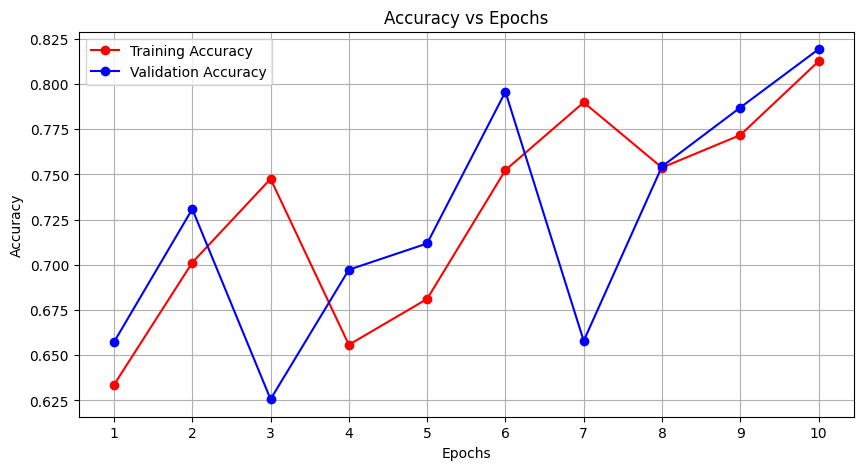

In [25]:
# Define the LSTM Classifier

class LSTMClassifier(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):

        super(LSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_dim, output_dim)



    def forward(self, x):

        # x should be of shape [batch_size, sequence_length, input_dim]

        x, _ = self.lstm(x)  # Output shape: [batch_size, sequence_length, hidden_dim]

        x = x[:, -1, :]  # Take the last output of the LSTM

        x = self.fc(x)  # Final linear layer

        return x



input_dim = 128

hidden_dim = 32

output_dim = 1  # For binary classification



lstm = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)

lstm_model = train_model_DARTS_LSTM(lstm, train_loader_DARTS_LSTM, val_loader_DARTS_LSTM, num_epochs=10, model_name='lstm_model')

In [27]:
from sklearn.metrics import f1_score

def evaluate_model(model, test_loader, device):
    """Evaluates the model on the test data, returning accuracy, F1 score, TNR, and TPR."""
    model.eval()

    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            true_positives += ((predictions == 1) & (labels == 1)).sum().item()
            true_negatives += ((predictions == 0) & (labels == 0)).sum().item()
            false_positives += ((predictions == 1) & (labels == 0)).sum().item()
            false_negatives += ((predictions == 0) & (labels == 1)).sum().item()

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='binary')

    tnr = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0.0
    tpr = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return accuracy, f1, tpr, tnr




def evaluate_model_DARTS_LSTM(model, test_loader_LSTM, device):
    """Evaluates the LSTM model on the test data, returning accuracy, F1 score, TNR, and TPR."""
    model.eval()

    correct = 0
    total = 0
    tn = 0
    fp = 0
    tp = 0
    fn = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in test_loader_LSTM:
            inputs = batch['x'].to(device)
            labels = batch['y'].to(device).float().unsqueeze(1)
            outputs = model(inputs)
            predictions = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)
            correct += (predictions.view(-1) == labels.view(-1)).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            tn += ((labels.view(-1) == 0) & (predictions.view(-1) == 0)).sum().item()
            fp += ((labels.view(-1) == 0) & (predictions.view(-1) == 1)).sum().item()
            tp += ((labels.view(-1) == 1) & (predictions.view(-1) == 1)).sum().item()
            fn += ((labels.view(-1) == 1) & (predictions.view(-1) == 0)).sum().item()

    accuracy = correct / total
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = f1_score(all_labels, all_predictions, average='binary')

    return accuracy, f1, tpr, tnr



def evaluate_model_gnn(model, test_loader, device):
    """Evaluates the GNN model on the test data, returning accuracy, F1 score, TNR, and TPR."""
    model.eval()

    correct = 0
    total = 0
    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            x, edge_index, batch = data.x, data.edge_index, data.batch
            labels = data.y.float().unsqueeze(1)
            outputs = model(x, edge_index, batch)
            predictions = (torch.sigmoid(outputs) > 0.5).float()

            total += labels.size(0)
            correct += (predictions == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            true_positives += ((predictions == 1) & (labels == 1)).sum().item()
            true_negatives += ((predictions == 0) & (labels == 0)).sum().item()
            false_positives += ((predictions == 1) & (labels == 0)).sum().item()
            false_negatives += ((predictions == 0) & (labels == 1)).sum().item()

    accuracy = correct / total
    f1 = f1_score(all_labels, all_predictions, average='binary')

    tnr = true_negatives / (true_negatives + false_positives) if (true_negatives + false_positives) > 0 else 0.0
    tpr = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0

    return accuracy, f1, tpr, tnr


In [28]:
# Define a function to evaluate and store results
def evaluate_and_store(model, model_name, test_loader, device):
    accuracy, f1, tpr, tnr = evaluate_model(model, test_loader, device)
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'TPR': tpr,
        'TNR': tnr
    }
def evaluate_and_store_gnn(model, model_name, test_loader, device):
    accuracy, f1, tpr, tnr = evaluate_model_gnn(model, test_loader, device)
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'TPR': tpr,
        'TNR': tnr
    }
def evaluate_and_store_DARTS_LSTM(model, model_name, test_loader, device):
    accuracy, f1, tpr, tnr = evaluate_model_DARTS_LSTM(model, test_loader, device)
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'TPR': tpr,
        'TNR': tnr
    }

# List to hold results
results = []

# Evaluate each model and store the results
results.append(evaluate_and_store(res2net_model, 'Res2Net', test_loader, device))
results.append(evaluate_and_store(senet_model, 'SENet', test_loader, device))
results.append(evaluate_and_store(resnet_model, 'ResNet', test_loader, device))
results.append(evaluate_and_store_gnn(gnn_model, 'GNN', test_loader_graph, device))
results.append(evaluate_and_store_DARTS_LSTM(Darts_model, 'DARTS', test_loader_DARTS_LSTM, device))
results.append(evaluate_and_store_DARTS_LSTM(lstm_model, 'LSTM', test_loader_DARTS_LSTM, device))

# Create a DataFrame for better visualization
import pandas as pd

results_df = pd.DataFrame(results)

# Display the results
results_df


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


,Model,Accuracy,F1 Score,TPR,TNR
0,Res2Net,0.910149,0.931695,0.981875,0.791058
1,SENet,0.950873,0.961828,0.991714,0.883061
2,ResNet,0.927602,0.943089,0.961160,0.871883
3,GNN,0.767938,0.834027,0.934231,0.491831
4,DARTS,0.624111,0.768557,1.000000,0.000000
5,LSTM,0.823853,0.863852,0.895391,0.705073
